In [3]:
# Imports (global)
import os
import re
import glob
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, leaves_list

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import TwoSlopeNorm

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Output dir: <notebook_folder>/figures
try:
    import ipynbname  # optional

    _NB_DIR = Path(ipynbname.path()).parent
except Exception:
    _NB_DIR = Path.cwd()

OUT_DIR = _NB_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Notebook dir:", _NB_DIR)
print("Figures dir:", OUT_DIR)


Notebook dir: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis
Figures dir: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures


# Data profiling – missingness & correlations
This notebook builds a panel from raw Excel files and analyzes missingness, correlations, and relationships to industrial production (IP).


In [4]:
## 1) Helpers: date parsing & missingness patterns
def _to_month_start(ts):
    if pd.isna(ts): return pd.NaT
    ts = pd.Timestamp(ts)
    return pd.Timestamp(ts.year, ts.month, 1)

DOT_DDMMYY = re.compile(r'^\s*\d{2}\.\d{2}\.(\d{2}|\d{4})\s*$')

def parse_month(x):
    if pd.isna(x): return pd.NaT
    if isinstance(x, (int, float)) and not np.isnan(x):
        return _to_month_start(pd.to_datetime(x, unit='d', origin='1899-12-30', errors='coerce'))
    s = str(x).strip()
    if DOT_DDMMYY.fullmatch(s):
        return _to_month_start(pd.to_datetime(s, dayfirst=True, errors='coerce'))
    if re.fullmatch(r"\d{2}[./]\d{4}", s):
        return _to_month_start(pd.to_datetime(s.replace(".", "/"), format="%m/%Y", errors="coerce"))
    if re.fullmatch(r"\d{4}[./]\d{2}", s):
        y, m = re.split(r"[./]", s); return pd.Timestamp(int(y), int(m), 1)
    if re.fullmatch(r"\d{4}", s):
        return pd.Timestamp(int(s), 1, 1)
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return _to_month_start(dt) if pd.notna(dt) else pd.NaT

def missing_pattern_report(df: pd.DataFrame):
    lead_flags, trail_flags, mid_flags, any_flags, only_flags = [], [], [], [], []

    for c in df.columns:
        a = df[c].isna().to_numpy()

        if not a.any():
            lead_flags.append(False)
            trail_flags.append(False)
            mid_flags.append(False)
            any_flags.append(False)
            only_flags.append(False)
            continue

        if a.all():
            only_flags.append(True)
        else:
            only_flags.append(False)

        lead = 0
        for v in a:
            if v: lead += 1
            else: break

        trail = 0
        for v in a[::-1]:
            if v: trail += 1
            else: break

        mid = a[lead:len(a)-trail].any() if (lead+trail) < len(a) else False

        lead_flags.append(lead > 0)
        trail_flags.append(trail > 0)
        mid_flags.append(mid)
        any_flags.append(True)

    lead_flags = np.array(lead_flags)
    trail_flags = np.array(trail_flags)
    mid_flags = np.array(mid_flags)
    any_flags = np.array(any_flags)
    only_flags = np.array(only_flags)

    return {
        "completely_NA": int(np.sum(only_flags)),
        "leading_only": int(np.sum(lead_flags & ~trail_flags & ~mid_flags & ~only_flags)),
        "trailing_only": int(np.sum(trail_flags & ~lead_flags & ~mid_flags & ~only_flags)),
        "mid_only": int(np.sum(mid_flags & ~lead_flags & ~trail_flags & ~only_flags)),
        "leading_and_trailing": int(np.sum(lead_flags & trail_flags & ~mid_flags & ~only_flags)),
        "leading_and_mid": int(np.sum(lead_flags & mid_flags & ~trail_flags & ~only_flags)),
        "trailing_and_mid": int(np.sum(trail_flags & mid_flags & ~lead_flags & ~only_flags)),
        "leading_trailing_mid": int(np.sum(lead_flags & trail_flags & mid_flags & ~only_flags)),
        "any_NA": int(np.sum(any_flags)),
    }

## 2) Build panel from raw Excel files

In [5]:
DATA_DIR = pathlib.Path("../../data/raw/features")
files = sorted(map(pathlib.Path, glob.glob(str(DATA_DIR / "bdi1a_*.xlsx"))))
if not files:
    raise FileNotFoundError("No bdi1a_*.xlsx files found")

long_frames = []
for p in files:
    df = pd.read_excel(p, skiprows=2, engine="openpyxl")
    date_col = df.columns[0]
    df = df.rename(columns={date_col: "date"})
    df["date"] = df["date"].map(parse_month)
    long_frames.append(df.melt(id_vars="date", var_name="title_raw", value_name="value"))

panel_long = pd.concat(long_frames, ignore_index=True).dropna(subset=["date"])

full_df = panel_long.pivot_table(
    index="date", columns="title_raw", values="value", aggfunc="last", dropna=False
)
full_df.index = pd.to_datetime(full_df.index, errors="coerce").to_period("M").to_timestamp()
full_df = full_df[~full_df.index.duplicated(keep="last")]

print("Full merged shape:", full_df.shape)

report = missing_pattern_report(full_df)
print("Missingness report (columns):")
for k, v in report.items():
    print(f"{k}: {v}")

Full merged shape: (410, 2655)
Missingness report (columns):
completely_NA: 1
leading_only: 435
trailing_only: 49
mid_only: 0
leading_and_trailing: 10
leading_and_mid: 0
trailing_and_mid: 0
leading_trailing_mid: 0
any_NA: 495


## 3) Paths & global settings

In [6]:
features_file = "../../data/processed/features.csv"  # all features incl. missing
target_file   = "../../data/processed/target.csv"    # IP (level + change?)

industry_whitelist = [
    # "Verarbeitendes_Gewerbe",
    # "Herstellung_von_Investitionsgütern",
]

rm_window = 12  # months

In [7]:
from pathlib import Path
import pandas as pd

tsfresh_file = Path(target_file).with_name("tsfresh_slim.parquet")
tsfresh = pd.read_parquet(tsfresh_file)

print("File:", tsfresh_file)
print("Shape (rows, cols):", tsfresh.shape)


File: ../../data/processed/tsfresh_slim.parquet
Shape (rows, cols): (407, 1554)


## 4) Target diagnostics: stationarity tests

In [8]:
df = pd.read_csv(target_file, parse_dates=["date"])
mom = df["IP_change"].dropna()

mom_pct = df["IP_change"].astype(float).dropna()
mom_rel = mom_pct / 100.0

print("IP_change in Prozentpunkten (0.8 = 0.8%):")
print("  n       :", len(mom_pct))
print("  mean    :", mom_pct.mean())
print("  var     :", mom_pct.var())
print("  std     :", mom_pct.std())

print("\nIP_change als relative Änderung (0.008 = 0.8%):")
print("  n       :", len(mom_rel))
print("  mean    :", mom_rel.mean())
print("  var     :", mom_rel.var())
print("  std     :", mom_rel.std())

def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f"--- {title} ---")
    print("ADF statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical value {key}: {value}")
    print()

adf_test(df["IP"], "IP (Level)")
adf_test(df["IP_change"], "IP_change (MoM)")
adf_test(df["IP_yoy"], "IP_yoy (YoY)")

IP_change in Prozentpunkten (0.8 = 0.8%):
  n       : 407
  mean    : 0.04274140564293427
  var     : 3.630184878853925
  std     : 1.9053044058244144

IP_change als relative Änderung (0.008 = 0.8%):
  n       : 407
  mean    : 0.00042741405642934247
  var     : 0.00036301848788539246
  std     : 0.019053044058244144
--- IP (Level) ---
ADF statistic: -1.6044180366906216
p-value: 0.481373795486562
Critical value 1%: -3.446599953548936
Critical value 5%: -2.86870295908671
Critical value 10%: -2.570585643956714

--- IP_change (MoM) ---
ADF statistic: -17.205325106153715
p-value: 6.420299971246067e-30
Critical value 1%: -3.446599953548936
Critical value 5%: -2.86870295908671
Critical value 10%: -2.570585643956714

--- IP_yoy (YoY) ---
ADF statistic: -4.955405065341206
p-value: 2.7174141954025406e-05
Critical value 1%: -3.4477686860685
Critical value 5%: -2.869216670067509
Critical value 10%: -2.570859500573892



## 5) Feature naming: canonical question types & splitting

In [9]:
QUESTION_CANON = [
    "auftragsbestand_beurteilung",
    "auftragsbestand_beurteilung_export",
    "auftragsbestand_gegen_vormonat",
    "beschaeftigtenerwartungen",
    "exporterwartungen",
    "fertigwarenlager_beurteilung",
    "geschaeftsklima",
    "geschaeftslage_beurteilung",
    "geschaeftslage_erwartungen",
    "nachfrage_gegen_vormonat",
    "preise_gegen_vormonat",
    "preiserwartungen",
    "produktion_gegen_vormonat",
    "produktionsplaene",
    "produktivitaetserwartungen"
]

def _slug(s: str) -> str:
    s = s.lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss")
           .replace(" ", "_").replace("-", "_"))
    s = re.sub(r"[^a-z0-9_\.]+", "", s)
    s = re.sub(r"\.+", ".", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("._")

def split_norm(col: str):
    s = _slug(col)
    for q in QUESTION_CANON:
        if s.endswith("." + q):
            ind = s[:-(len(q)+1)].strip("._")
            return ind, q
        if s.endswith(q):
            before = s[:-(len(q))]
            if before.endswith("."):
                ind = before[:-1].strip("._")
                return ind, q
    if "." in s:
        ind, qraw = s.rsplit(".", 1)
        q = re.sub(r"^(?:\d+\.|n\.?g\.?|ng\.?)+", "", qraw)
        q = q.strip("._")
        return ind.strip("._"), q
    return "", s

## 6) Load processed features/targets and align time index

In [10]:
def _read_timeseries_csv(path):
    df = pd.read_csv(path)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    else:
        df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
        df = df.set_index(df.columns[0])
    return df.sort_index()

X_full = _read_timeseries_csv(features_file)
y_df   = _read_timeseries_csv(target_file)

X_original = _read_timeseries_csv("../../data/processed/features.csv")

X_original_NA_cutted = X_original.copy()
while X_original_NA_cutted.iloc[0].isna().any():
    X_original_NA_cutted = X_original_NA_cutted.iloc[1:]
while X_original_NA_cutted.iloc[-1].isna().any():
    X_original_NA_cutted = X_original_NA_cutted.iloc[:-1]

y_cols = list(y_df.columns)
if len(y_cols) >= 2:
    y_level  = y_df.iloc[:,0].astype(float)
    y_change = y_df.iloc[:,1].astype(float)
else:
    y_level  = y_df.iloc[:,0].astype(float)
    y_change = y_level.diff()

if industry_whitelist:
    wl = set(industry_whitelist)
    keep = [c for c in X_full.columns if c.split('.',1)[0] in wl]
    X_full = X_full[keep]
    X_original = X_original[keep]
    X_original_NA_cutted = X_original_NA_cutted[keep]
    print(f"Filtered columns: {len(keep)}")

idx = X_full.index.intersection(y_df.index)
X_full = X_full.loc[idx]
y_level = y_level.loc[idx]
y_change = y_change.loc[idx]

print("X_full", X_full.shape, "y_change", y_change.shape)
print("X_original_NA_cutted", X_original_NA_cutted.shape)


X_full (408, 2654) y_change (408,)
X_original_NA_cutted (141, 2654)


## 7) Missingness summary on X_full

In [11]:
def missing_pattern_report(df: pd.DataFrame):
    lead_flags, trail_flags, mid_flags, any_flags = [], [], [], []

    for c in df.columns:
        a = df[c].isna().to_numpy()
        if not a.any():
            lead_flags.append(False)
            trail_flags.append(False)
            mid_flags.append(False)
            any_flags.append(False)
            continue

        lead = 0
        for v in a:
            if v: lead += 1
            else: break

        trail = 0
        for v in a[::-1]:
            if v: trail += 1
            else: break

        mid = a[lead:len(a)-trail].any() if (lead+trail) < len(a) else False

        lead_flags.append(lead > 0)
        trail_flags.append(trail > 0)
        mid_flags.append(mid)
        any_flags.append(True)

    lead_flags = np.array(lead_flags)
    trail_flags = np.array(trail_flags)
    mid_flags = np.array(mid_flags)
    any_flags = np.array(any_flags)

    report = {
        "leading_only": int(np.sum(lead_flags & ~trail_flags & ~mid_flags)),
        "trailing_only": int(np.sum(trail_flags & ~lead_flags & ~mid_flags)),
        "mid_only": int(np.sum(mid_flags & ~lead_flags & ~trail_flags)),
        "leading_and_trailing": int(np.sum(lead_flags & trail_flags & ~mid_flags)),
        "leading_and_mid": int(np.sum(lead_flags & mid_flags & ~trail_flags)),
        "trailing_and_mid": int(np.sum(trail_flags & mid_flags & ~lead_flags)),
        "leading_trailing_mid": int(np.sum(lead_flags & trail_flags & mid_flags)),
        "any_NA": int(np.sum(any_flags)),
    }
    return report

report = missing_pattern_report(X_full)
for k,v in report.items():
    print(f"{k}: {v}")

leading_only: 436
trailing_only: 48
mid_only: 0
leading_and_trailing: 9
leading_and_mid: 0
trailing_and_mid: 0
leading_trailing_mid: 0
any_NA: 493


## 8) Correlation distribution (pairwise)

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/correlation_distribution.png


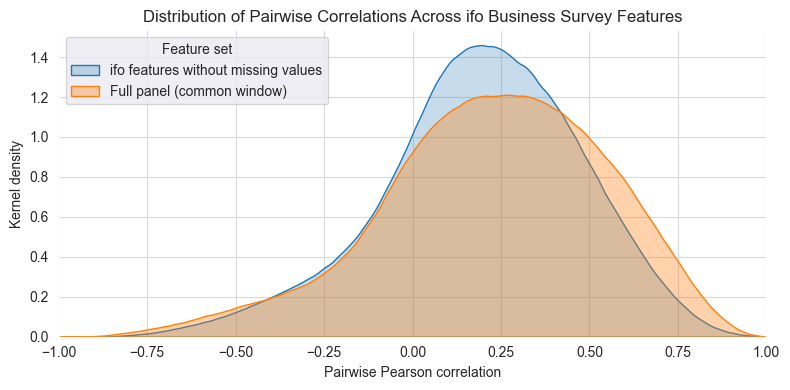

In [19]:
corr_full = X_full.corr()
corr_cut  = X_original_NA_cutted.corr()

mask = np.tril(np.ones(corr_full.shape, dtype=bool))
vals_full = corr_full.where(~mask).stack().values
vals_cut  = corr_cut.where(~mask).stack().values

plt.figure(figsize=(8, 4), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

sns.kdeplot(
    vals_full,
    fill=True,
    bw_adjust=0.6,
    label="ifo features without missing values",
    ax=ax
)
sns.kdeplot(
    vals_cut,
    fill=True,
    bw_adjust=0.6,
    alpha=0.35,
    label="Full panel (common window)",
    ax=ax
)

ax.set_facecolor("white")          # nach seaborn nochmal erzwingen
ax.grid(True, color="0.85")        # Grid behalten

plt.xlim(-1, 1)
plt.xlabel("Pairwise Pearson correlation")
plt.ylabel("Kernel density")
plt.title("Distribution of Pairwise Correlations Across ifo Business Survey Features")
plt.legend(frameon=True, title="Feature set")
plt.tight_layout()

save_path = OUT_DIR / "correlation_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
print(f"Saved to: {save_path}")

plt.show()

## 9) Missingness flags per column (lead/mid/trail)

In [13]:
def missing_pattern_flags(s: pd.Series):
    a = s.isna().to_numpy()
    if not a.any():
        return False, False, False, False  # has, lead, mid, trail
    lead = 0
    for v in a:
        if v: lead += 1
        else: break
    trail = 0
    for v in a[::-1]:
        if v: trail += 1
        else: break
    has = True
    if lead + trail >= len(a):
        mid = False
    else:
        mid = a[lead:len(a)-trail].any()
    return has, (lead>0), mid, (trail>0)

flags = np.array([missing_pattern_flags(X_full[c]) for c in X_full.columns], dtype=bool)
if flags.size == 0:
    raise ValueError("No columns in X_full.")

has_miss = flags[:,0]
lead = flags[:,1]
mid  = flags[:,2]
trail= flags[:,3]

n = X_full.shape[1]
pct = lambda k: 100.0 * k / n

print(f"% with ≥1 missing:  {pct(has_miss.sum()):.1f}")
print(f"% missing at start: {pct(lead.sum()):.1f}")
print(f"% missing in middle:{pct(mid.sum()):.1f}")
print(f"% missing at end:   {pct(trail.sum()):.1f}")
print("-- combinations --")
print(f"% start & end:      {pct((lead & trail).sum()):.1f}")
print(f"% start & middle:   {pct((lead & mid).sum()):.1f}")
print(f"% end & middle:     {pct((trail & mid).sum()):.1f}")

% with ≥1 missing:  18.6
% missing at start: 16.8
% missing in middle:0.0
% missing at end:   2.1
-- combinations --
% start & end:      0.3
% start & middle:   0.0
% end & middle:     0.0


## 10) Missing rate per question + leading-NA share per question

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/missing_rate_per_question.png


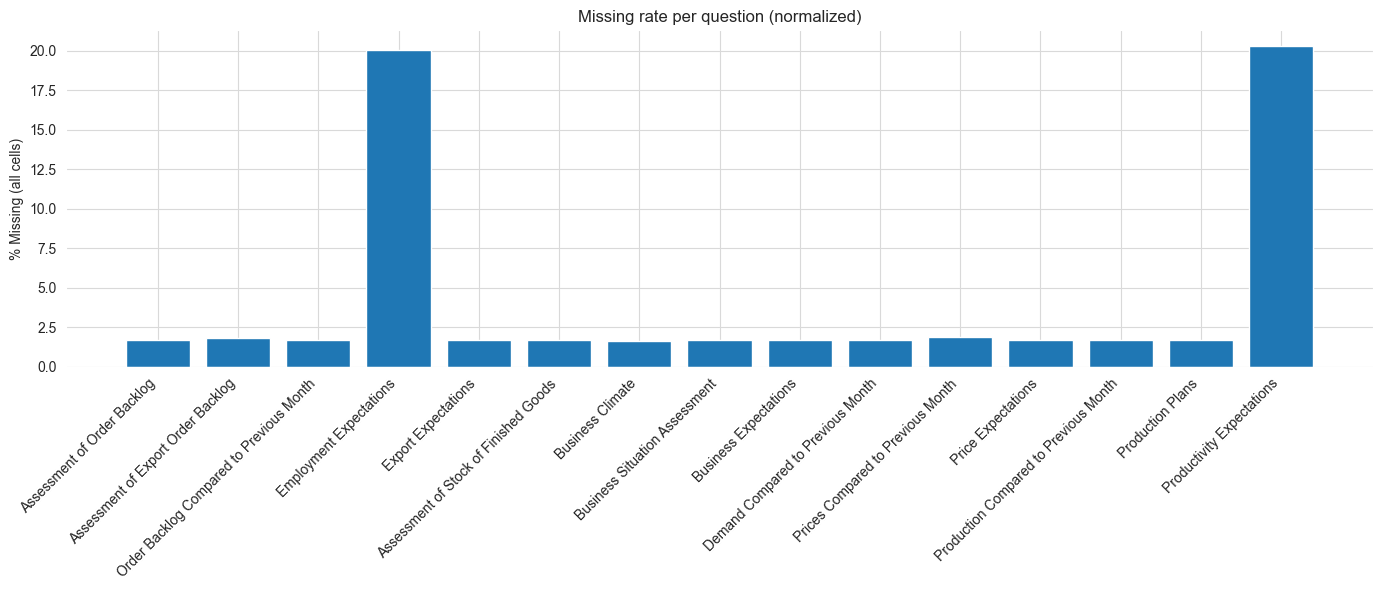

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/leading_NA_share_per_question.png


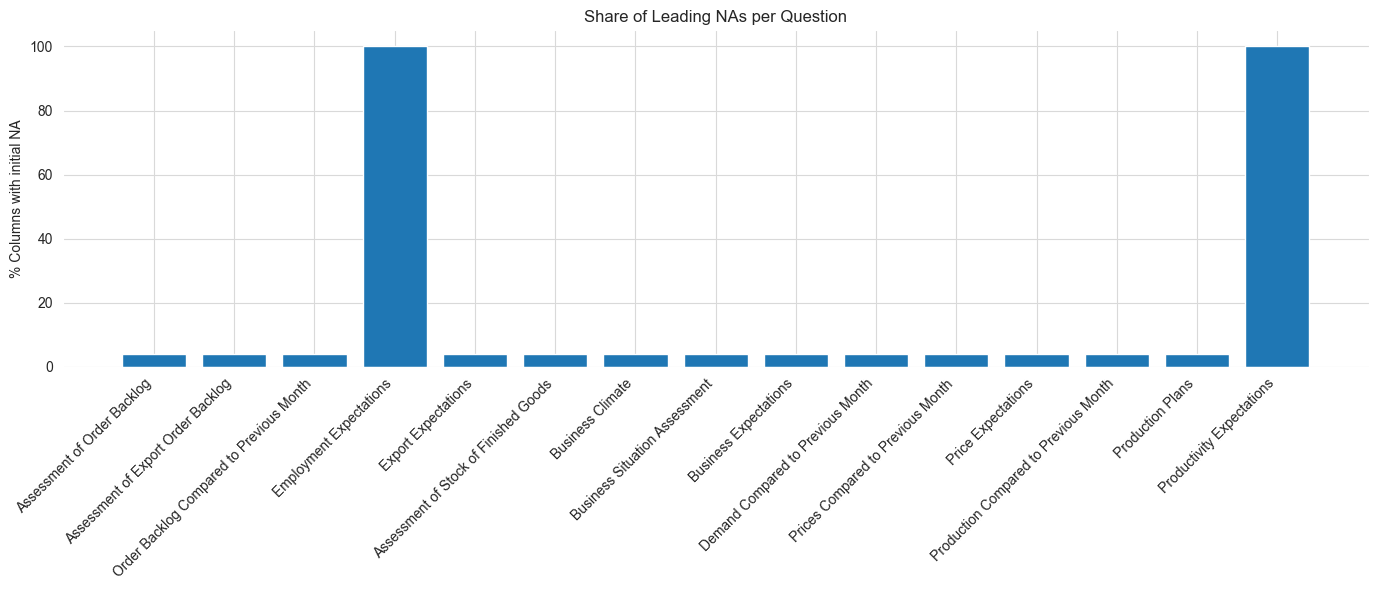

In [14]:
mapping = {
    "geschaeftsklima": "Business Climate",
    "geschaeftslage_beurteilung": "Business Situation Assessment",
    "geschaeftslage_erwartungen": "Business Expectations",
    "beschaeftigungserwartung": "Employment Expectations",
    "fertigwarenlager_beurteilung": "Assessment of Stock of Finished Goods",
    "auftragsbestand_beurteilung": "Assessment of Order Backlog",
    "auftragsbestand_beurteilung_export": "Assessment of Export Order Backlog",
    "nachfrage_gegen_vormonat": "Demand Compared to Previous Month",
    "auftragsbestand_gegen_vormonat": "Order Backlog Compared to Previous Month",
    "produktion_gegen_vormonat": "Production Compared to Previous Month",
    "preise_gegen_vormonat": "Prices Compared to Previous Month",
    "produktionsplaene": "Production Plans",
    "preiserwartungen": "Price Expectations",
    "exporterwartungen": "Export Expectations",
    "beschaeftigtenerwartungen": "Employment Expectations",
    "produktivitaetserwartungen": "Productivity Expectations"
}

def missing_pattern_flags(s: pd.Series):
    a = s.isna().to_numpy()
    if not a.any(): return False, False, False, False
    lead = 0
    for v in a:
        if v: lead += 1
        else: break
    trail = 0
    for v in a[::-1]:
        if v: trail += 1
        else: break
    mid = a[lead:len(a)-trail].any() if (lead+trail) < len(a) else False
    return True, (lead>0), mid, (trail>0)

by_qnorm = {}
for c in X_full.columns:
    _, qn = split_norm(c)
    if qn:
        by_qnorm.setdefault(qn, []).append(c)

q_missing_rate, q_leading_share = {}, {}
for qn, cols in by_qnorm.items():
    sub = X_full[cols]
    miss_rate = sub.isna().sum().sum() / (sub.shape[0]*sub.shape[1])
    lead_mask = [missing_pattern_flags(X_full[c])[1] for c in cols]
    q_missing_rate[qn] = miss_rate
    q_leading_share[qn] = (np.sum(lead_mask) / len(cols)) if cols else 0.0

qs = list(q_missing_rate.keys())

vals = [q_missing_rate[q]*100 for q in qs]
labels = [mapping.get(q, q) for q in qs]

# --- Plot 1: Missing Rate ---
plt.figure(figsize=(14,6), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

plt.bar(labels, vals)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% Missing (all cells)")
plt.title("Missing rate per question (normalized)")

ax.grid(True, color="0.85")

plt.tight_layout()

save_path1 = OUT_DIR / "missing_rate_per_question.png"
plt.savefig(save_path1, dpi=300, bbox_inches='tight', facecolor="white")
print(f"Saved to: {save_path1}")

plt.show()

# --- Plot 2: Leading NA Share ---
vals2 = [q_leading_share[q]*100 for q in qs]

plt.figure(figsize=(14,6), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

plt.bar(labels, vals2)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% Columns with initial NA")
plt.title("Share of Leading NAs per Question")

ax.grid(True, color="0.85")

plt.tight_layout()

save_path2 = OUT_DIR / "leading_NA_share_per_question.png"
plt.savefig(save_path2, dpi=300, bbox_inches='tight', facecolor="white")
print(f"Saved to: {save_path2}")

plt.show()

## 11) Leading & trailing NAs over time: still-missing share (abs/rel)

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/leading_trailing_NA_share_abs.png


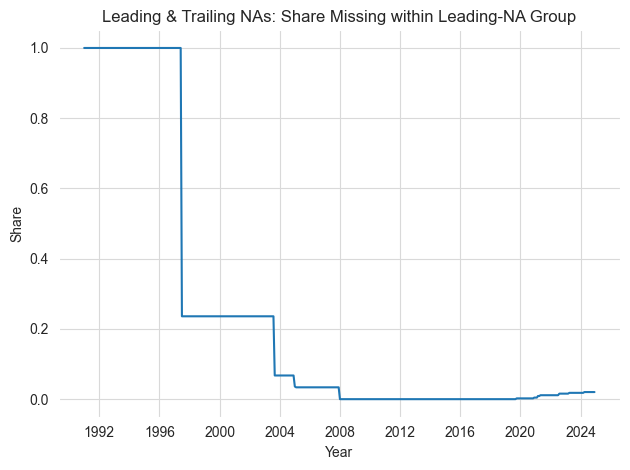

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/leading_trailing_NA_share_rel.png


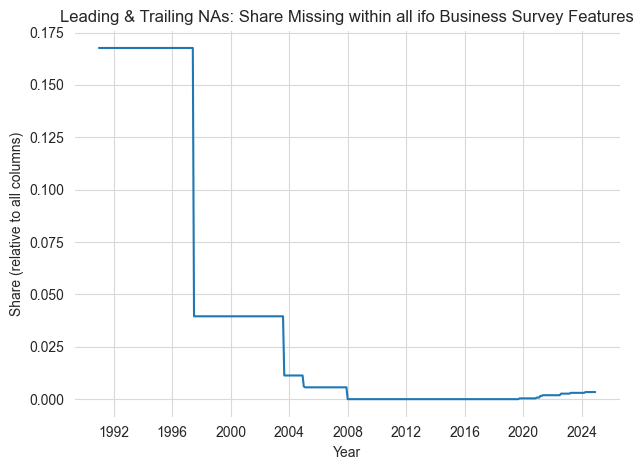

340 series start at 1997-07-01
75 series start at 2003-09-01
14 series start at 2005-01-01
1 series start at 2005-02-01
15 series start at 2008-01-01
436 series end at 2024-12-01
1 series end at 2024-03-01
1 series end at 2023-03-01
2 series end at 2022-07-01
1 series end at 2021-04-01
2 series end at 2021-02-01
1 series end at 2020-11-01
1 series end at 2019-09-01


In [16]:
lead_cols = [c for c, l in zip(X_full.columns, lead) if l]
if len(lead_cols) == 0:
    print("No columns with leading NAs")
else:
    fvi_lead, fvi_trail = {}, {}
    arr_index = np.arange(len(X_full.index))

    for c in lead_cols:
        a = X_full[c].isna().to_numpy()

        lv = 0
        for v in a:
            if v: lv += 1
            else: break
        fvi_lead[c] = lv

        tv = 0
        for v in a[::-1]:
            if v: tv += 1
            else: break
        fvi_trail[c] = tv

    fvi_lead_vals = np.array(list(fvi_lead.values()))
    fvi_trail_vals = np.array(list(fvi_trail.values()))

    abs_curve = []
    for t in arr_index:
        still_missing = (fvi_lead_vals > t).sum() + (fvi_trail_vals > (len(arr_index)-1-t)).sum()
        abs_curve.append(still_missing / len(lead_cols))

    rel_curve = []
    denom = X_full.shape[1]
    for t in arr_index:
        still_missing = (fvi_lead_vals > t).sum() + (fvi_trail_vals > (len(arr_index)-1-t)).sum()
        rel_curve.append(still_missing / denom)

    # --- Plot 1: Absolute Share ---
    plt.figure(facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")

    plt.plot(X_full.index, abs_curve)
    plt.xlabel("Year")
    plt.ylabel("Share")
    plt.title("Leading & Trailing NAs: Share Missing within Leading-NA Group")

    ax.grid(True, color="0.85")

    plt.tight_layout()

    save_path1 = OUT_DIR / "leading_trailing_NA_share_abs.png"
    plt.savefig(save_path1, dpi=300, bbox_inches='tight', facecolor="white")
    print(f"Saved to: {save_path1}")

    plt.show()

    # --- Plot 2: Relative Share ---
    plt.figure(facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")

    plt.plot(X_full.index, rel_curve)
    plt.xlabel("Year")
    plt.ylabel("Share (relative to all columns)")
    plt.title("Leading & Trailing NAs: Share Missing within all ifo Business Survey Features")

    ax.grid(True, color="0.85")

    plt.tight_layout()

    save_path2 = OUT_DIR / "leading_trailing_NA_share_rel.png"
    plt.savefig(save_path2, dpi=300, bbox_inches='tight', facecolor="white")
    print(f"Saved to: {save_path2}")

    plt.show()

jump_counts_lead = pd.Series(fvi_lead_vals).value_counts().sort_index()
for pos, count in jump_counts_lead.items():
    print(f"{count} series start at {X_full.index[pos].date()}")

jump_counts_trail = pd.Series(fvi_trail_vals).value_counts().sort_index()
for pos, count in jump_counts_trail.items():
    print(f"{count} series end at {X_full.index[-pos-1].date()}")

## 12) Target plots: IP level and MoM change


--- Correlation summary (all values across lags) ---
Max correlation coefficient (signed): 0.3507
Min correlation coefficient (signed): -0.2004
Max absolute correlation coefficient: 0.3507 (corr=0.3507, lag=0)
Share with |corr| < 0.1: 88.73% 
Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/correlation_distribution_per_lag_0-6_nona_features.png


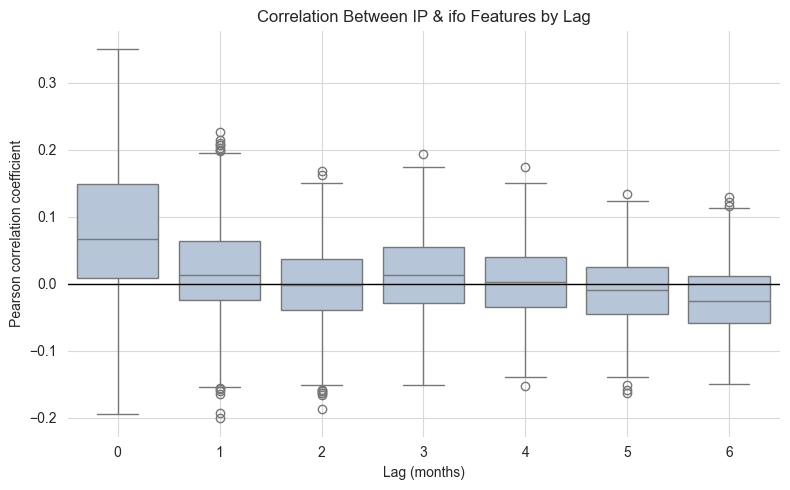

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/median_abs_correlation_per_lag_0-6_nona_features.png


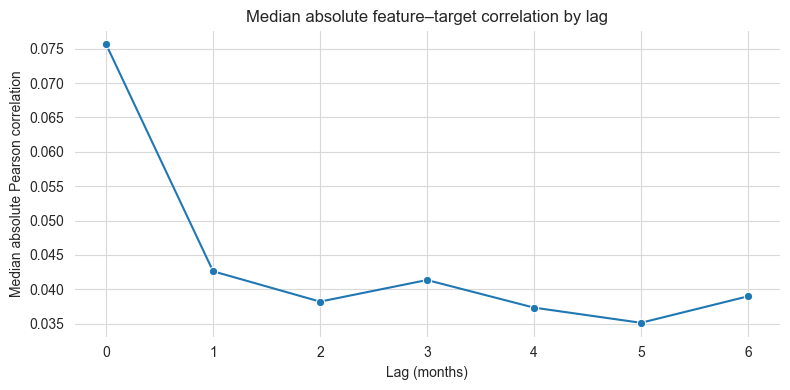

In [18]:
# 1) keep only features with no missing values (as in your original chunk)
complete_feats = X_full.columns[X_full.notna().all(axis=0)]
complete_set = set(complete_feats)

# 2) build mats (per question: corr matrix with index=lag, columns=feature)
# Convention: lag k => corr( X_{t-k}, y_t )  (past X predicts current y)
MAX_LAG = 6

# align X and y first
idx = X_full.index.intersection(y_change.index)
Xc = X_full.loc[idx, list(complete_feats)].copy()
yc = y_change.loc[idx].astype(float).rename("y")

# group columns by normalized question
by_q = {}
for c in Xc.columns:
    _, qn = split_norm(c)
    qn = qn or "unknown"
    by_q.setdefault(qn, []).append(c)

mats = {}
for qn, cols in by_q.items():
    M = pd.DataFrame(index=range(0, MAX_LAG + 1), columns=cols, dtype=float)
    for k in range(0, MAX_LAG + 1):
        tmp = pd.concat([Xc[cols].shift(k), yc], axis=1).dropna()
        if len(tmp) >= 3:
            M.loc[k, cols] = tmp[cols].corrwith(tmp["y"])
        else:
            M.loc[k, cols] = np.nan
    mats[qn] = M

# 3) keep only questions with at least one finite corr value in lags 0..6
mats_complete = {}
for qn, M in mats.items():
    M2 = M.loc[0:MAX_LAG]
    if np.isfinite(M2.to_numpy()).any():
        mats_complete[qn] = M2

# 4) flatten to long df for plotting
records = []
for qn, M in mats_complete.items():
    for lag in M.index:
        lag_int = int(lag)
        vals = M.loc[lag].dropna().astype(float).values
        records.extend([{"lag": lag_int, "corr": v} for v in vals])

df_corrs = pd.DataFrame(records)
if df_corrs.empty:
    raise ValueError(
        "No correlations left. Check that X_full/y_change overlap in time, "
        "and that you have NA-free feature series with enough observations."
    )

df_corrs["lag"] = pd.Categorical(df_corrs["lag"], categories=list(range(0, MAX_LAG + 1)), ordered=True)

# --- Added summary stats (printed in English) ---
abs_corr = df_corrs["corr"].abs()
max_abs_val = float(abs_corr.max())
imax = int(abs_corr.idxmax())
max_abs_row = df_corrs.loc[imax]
count_small = int((abs_corr < 0.1).sum())
pct_small = 100.0 * count_small / len(df_corrs)

print("\n--- Correlation summary (all values across lags) ---")
print(f"Max correlation coefficient (signed): {df_corrs['corr'].max():.4f}")
print(f"Min correlation coefficient (signed): {df_corrs['corr'].min():.4f}")
print(
    f"Max absolute correlation coefficient: {max_abs_val:.4f} "
    f"(corr={float(max_abs_row['corr']):.4f}, lag={int(max_abs_row['lag'])})"
)
print(f"Share with |corr| < 0.1: {pct_small:.2f}% ")

# 5) Boxplot: correlation distribution per lag
plt.figure(figsize=(8, 5), facecolor="white")  # Hintergrund der Figure weiß
ax = plt.gca()
ax.set_facecolor("white")                      # Hintergrund der Achsen weiß

sns.boxplot(data=df_corrs, x="lag", y="corr", color="lightsteelblue", ax=ax)
ax.axhline(0, color="k", lw=1)

ax.grid(True, color="0.85")                    # Grid-Farbe angepasst

plt.title("Correlation Between IP & ifo Features by Lag")
plt.xlabel("Lag (months)")
plt.ylabel("Pearson correlation coefficient")
plt.tight_layout()

save_path1 = OUT_DIR / f"correlation_distribution_per_lag_0-{MAX_LAG}_nona_features.png"
plt.savefig(save_path1, dpi=300, bbox_inches="tight", facecolor="white") # facecolor beim Speichern
print(f"Saved to: {save_path1}")
plt.show()

# 6) Lineplot: median absolute correlation per lag
df_abs = df_corrs.assign(abs_corr=lambda d: d["corr"].abs())
lag_summary = df_abs.groupby("lag", observed=True)["abs_corr"].median().reset_index()

plt.figure(figsize=(8, 4), facecolor="white")  # Hintergrund der Figure weiß
ax = plt.gca()
ax.set_facecolor("white")                      # Hintergrund der Achsen weiß

sns.lineplot(data=lag_summary, x="lag", y="abs_corr", marker="o", ax=ax)

ax.grid(True, color="0.85")                    # Grid-Farbe angepasst

plt.title("Median absolute feature–target correlation by lag")
plt.xlabel("Lag (months)")
plt.ylabel("Median absolute Pearson correlation")
plt.tight_layout()

save_path2 = OUT_DIR / f"median_abs_correlation_per_lag_0-{MAX_LAG}_nona_features.png"
plt.savefig(save_path2, dpi=300, bbox_inches="tight", facecolor="white") # facecolor beim Speichern
print(f"Saved to: {save_path2}")
plt.show()

## 13) Feature–target correlations by question (lags 0–12)


--- Correlation summary (all values across lags) ---
Max correlation coefficient (signed): 0.3507
Min correlation coefficient (signed): -0.2004
Max absolute correlation coefficient: 0.3507 (corr=0.3507, lag=0)
Share with |corr| < 0.1: 88.73% 
Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/correlation_distribution_per_lag_0-6_nona_features.png


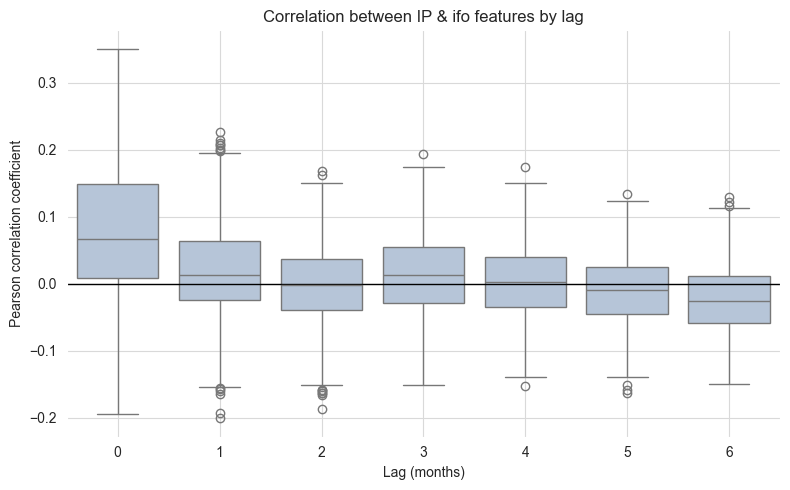

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/median_abs_correlation_per_lag_0-6_nona_features.png


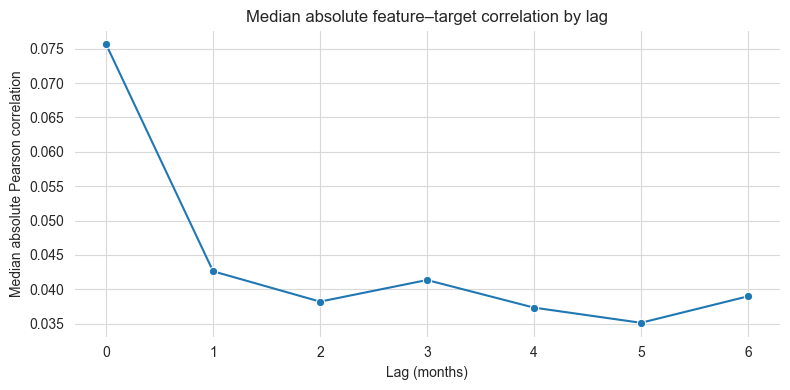

In [37]:



# 1) keep only features with no missing values (as in your original chunk)
complete_feats = X_full.columns[X_full.notna().all(axis=0)]
complete_set = set(complete_feats)

# 2) build mats (per question: corr matrix with index=lag, columns=feature)
# Convention: lag k => corr( X_{t-k}, y_t )  (past X predicts current y)
MAX_LAG = 6

# align X and y first
idx = X_full.index.intersection(y_change.index)
Xc = X_full.loc[idx, list(complete_feats)].copy()
yc = y_change.loc[idx].astype(float).rename("y")

# group columns by normalized question
by_q = {}
for c in Xc.columns:
    _, qn = split_norm(c)
    qn = qn or "unknown"
    by_q.setdefault(qn, []).append(c)

mats = {}
for qn, cols in by_q.items():
    M = pd.DataFrame(index=range(0, MAX_LAG + 1), columns=cols, dtype=float)
    for k in range(0, MAX_LAG + 1):
        tmp = pd.concat([Xc[cols].shift(k), yc], axis=1).dropna()
        if len(tmp) >= 3:
            M.loc[k, cols] = tmp[cols].corrwith(tmp["y"])
        else:
            M.loc[k, cols] = np.nan
    mats[qn] = M

# 3) keep only questions with at least one finite corr value in lags 0..6
mats_complete = {}
for qn, M in mats.items():
    M2 = M.loc[0:MAX_LAG]
    if np.isfinite(M2.to_numpy()).any():
        mats_complete[qn] = M2

# 4) flatten to long df for plotting
records = []
for qn, M in mats_complete.items():
    for lag in M.index:
        lag_int = int(lag)
        vals = M.loc[lag].dropna().astype(float).values
        records.extend([{"lag": lag_int, "corr": v} for v in vals])

df_corrs = pd.DataFrame(records)
if df_corrs.empty:
    raise ValueError(
        "No correlations left. Check that X_full/y_change overlap in time, "
        "and that you have NA-free feature series with enough observations."
    )

df_corrs["lag"] = pd.Categorical(df_corrs["lag"], categories=list(range(0, MAX_LAG + 1)), ordered=True)

# --- Added summary stats (printed in English) ---
abs_corr = df_corrs["corr"].abs()
max_abs_val = float(abs_corr.max())
imax = int(abs_corr.idxmax())
max_abs_row = df_corrs.loc[imax]
count_small = int((abs_corr < 0.1).sum())
pct_small = 100.0 * count_small / len(df_corrs)

print("\n--- Correlation summary (all values across lags) ---")
print(f"Max correlation coefficient (signed): {df_corrs['corr'].max():.4f}")
print(f"Min correlation coefficient (signed): {df_corrs['corr'].min():.4f}")
print(
    f"Max absolute correlation coefficient: {max_abs_val:.4f} "
    f"(corr={float(max_abs_row['corr']):.4f}, lag={int(max_abs_row['lag'])})"
)
print(f"Share with |corr| < 0.1: {pct_small:.2f}% ")

# 5) Boxplot: correlation distribution per lag
plt.figure(figsize=(8, 5), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

sns.boxplot(data=df_corrs, x="lag", y="corr", color="lightsteelblue", ax=ax)
ax.axhline(0, color="k", lw=1)

ax.grid(True, color="0.85")

plt.title("Correlation between IP & ifo features by lag")
plt.xlabel("Lag (months)")
plt.ylabel("Pearson correlation coefficient")
plt.tight_layout()

save_path1 = OUT_DIR / f"correlation_distribution_per_lag_0-{MAX_LAG}_nona_features.png"
plt.savefig(save_path1, dpi=300, bbox_inches="tight", facecolor="white")
print(f"Saved to: {save_path1}")
plt.show()

# 6) Lineplot: median absolute correlation per lag
df_abs = df_corrs.assign(abs_corr=lambda d: d["corr"].abs())
lag_summary = df_abs.groupby("lag", observed=True)["abs_corr"].median().reset_index()

plt.figure(figsize=(8, 4), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

sns.lineplot(data=lag_summary, x="lag", y="abs_corr", marker="o", ax=ax)

ax.grid(True, color="0.85")

plt.title("Median absolute feature–target correlation by lag")
plt.xlabel("Lag (months)")
plt.ylabel("Median absolute Pearson correlation")
plt.tight_layout()

save_path2 = OUT_DIR / f"median_abs_correlation_per_lag_0-{MAX_LAG}_nona_features.png"
plt.savefig(save_path2, dpi=300, bbox_inches="tight", facecolor="white")
print(f"Saved to: {save_path2}")
plt.show()


## 14) Autocorrelation of ΔIP (lags 1–6) + Ljung–Box

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/autocorrelation_delta_ip_1-6.png


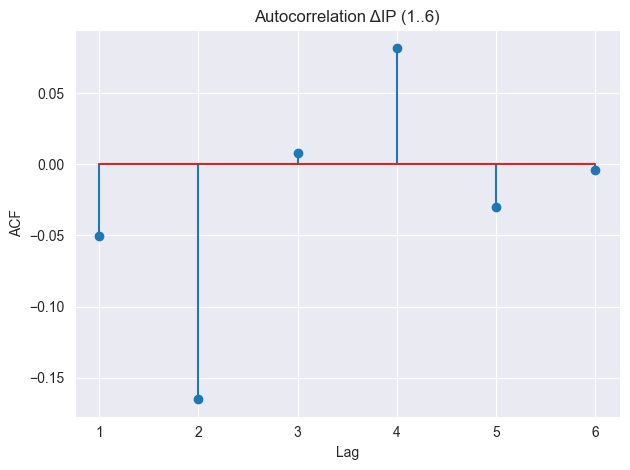

Saved to: /Users/jonasschernich/Documents/Masterarbeit/Code/notebooks/descriptive_analysis/figures/autocorrelation_delta_ip_confband_1-6.png


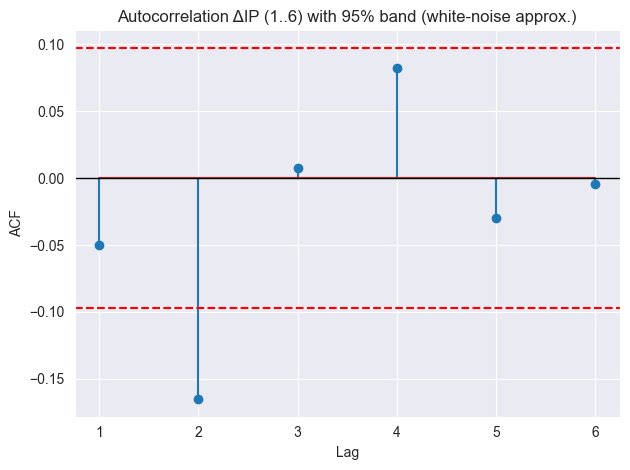


Ljung–Box test (H0: no autocorrelation up to lag h):
     lb_stat  lb_pvalue
1   1.021358   0.312197
2  12.132385   0.002320
3  12.156386   0.006866
4  14.889817   0.004935
5  15.245304   0.009364
6  15.252538   0.018381


In [20]:
y_change = df["IP_change"].dropna()

lags = range(1, 7)
vals = []
for k in lags:
    a = pd.concat([y_change.shift(k), y_change], axis=1).dropna()
    if len(a) < 3:
        vals.append(np.nan)
    else:
        vals.append(float(np.corrcoef(a.iloc[:, 0], a.iloc[:, 1])[0, 1]))

plt.figure()
plt.stem(list(lags), vals)
plt.title("Autocorrelation ΔIP (1..6)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

save_path1 = OUT_DIR / "autocorrelation_delta_ip_1-6.png"
plt.savefig(save_path1, dpi=300, bbox_inches="tight")
print(f"Saved to: {save_path1}")
plt.show()

n = len(y_change)
conf = 1.96 / np.sqrt(n)

plt.figure()
plt.stem(list(lags), vals)
plt.axhline(y=0, color="black", linewidth=1)
plt.axhline(y=conf, color="red", linestyle="--")
plt.axhline(y=-conf, color="red", linestyle="--")
plt.title("Autocorrelation ΔIP (1..6) with 95% band (white-noise approx.)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

save_path2 = OUT_DIR / "autocorrelation_delta_ip_confband_1-6.png"
plt.savefig(save_path2, dpi=300, bbox_inches="tight")
print(f"Saved to: {save_path2}")
plt.show()

lb = acorr_ljungbox(y_change, lags=list(lags), return_df=True)
print("\nLjung–Box test (H0: no autocorrelation up to lag h):")
print(lb)